##### <p> Samuel Wolfe <br> November 25, 2023 <br> MSBA 207 <br> Case: Market Basket Analysis </p>

In [11]:
# need to run "pip install mlxtend" first
# need to run "pip install surprise" first
# "conda install -c conda-forge scikit-surprise" in "terminal" (Mac) or "Anaconda Prompt" (Windows)
%matplotlib inline
from IPython.display import clear_output

from pathlib import Path

import heapq
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
pd.set_option('display.width', 250)

In [12]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('E:/Aliit/School/MSBA/206/MSBA-206/dmba')
#DATA = Path('C:/Users/Min Li/OneDrive/teaching/DS110/dmba')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)
# Load and preprocess data set 

Market Basket Analysis - Shopping Mall Customers

The Income DataLinks to an external site. (uncompress first) consist of 9,409 questionnaires <br>
filled out by shopping mall customers in the San Francisco Bay Area. The data contain answers<br>
to the first 14 questions, relating to demographics, as listed in the data dictionaryLinks to an external site.<br>
and shown below:

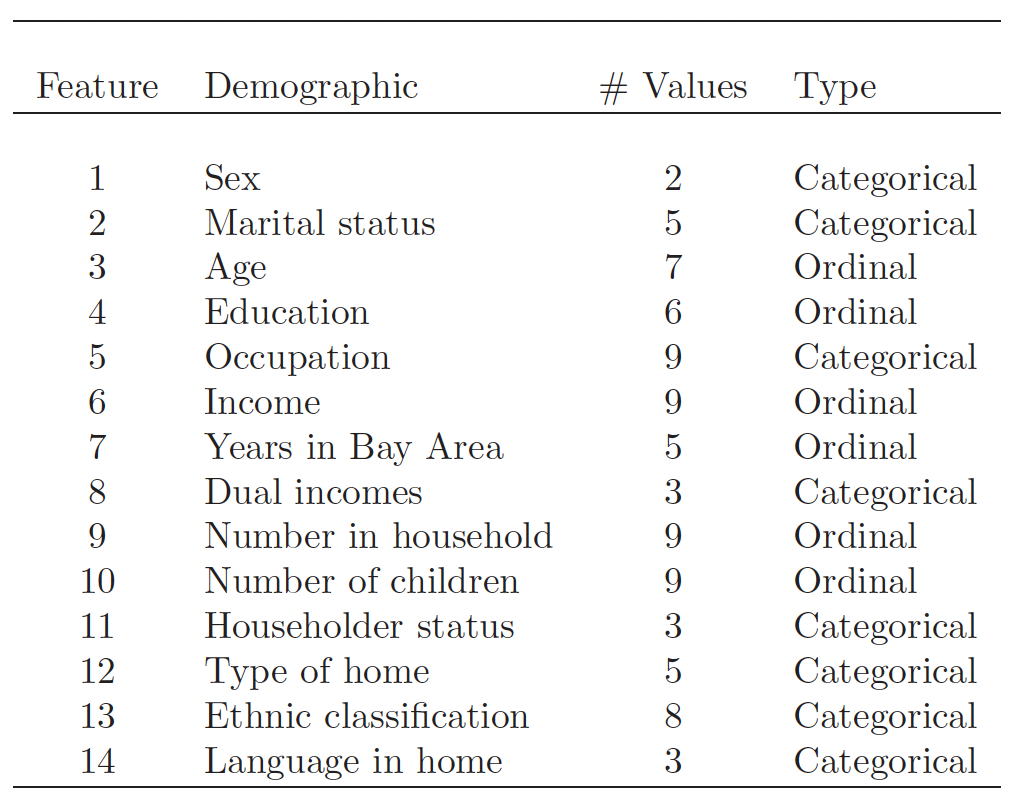

The data consist of a mixture of ordinal and (unordered) categorical variables, many of the latter having more than a few values.<br>
There are many missing values. Remove observations with missing values.<br>
Cut each ordinal predictor at its median and code it by two dummy variables.<br>
Code each categorical predictor with k categories by k dummy variables.<br>
Perform a Market Basket Analysis using the Apriori algorithm.<br>
Try a minimum support of 0.1 and minimum confidence level of 0.8 first and explain a few<br>
association rules that can be used by the business, e.g., to increase sales, understand its customers, etc.<br>
Then try other levels of minimum support and confidence to see what other interesting association rules you may be able to find.

In [13]:
categoricals = ['sex','married','occupation','dual','householder','type','ethnicity','language']
ordinals = ['age','education','income','residence','persons_in','persons_under']

In [14]:
df_mark = pd.read_csv(DATA / 'marketing.csv').dropna()
#Removing spaces from column names
names = df_mark.columns.to_list()
for x in names:
    df_mark = df_mark.rename(columns={x:x.replace(' ','_')})
df_mark

,income,sex,married,age,education,occupation,residence,dual,persons_in,persons_under,householder,type,ethnicity,language
1,9,1,1.0,5,5.0,5.0,5.0,3,5.0,2,1.0,1.0,7.0,1.0
2,9,2,1.0,3,5.0,1.0,5.0,2,3.0,1,2.0,3.0,7.0,1.0
3,1,2,5.0,1,2.0,6.0,5.0,1,4.0,2,3.0,1.0,7.0,1.0
4,1,2,5.0,1,2.0,6.0,3.0,1,4.0,2,3.0,1.0,7.0,1.0
5,8,1,1.0,6,4.0,8.0,5.0,3,2.0,0,1.0,1.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8988,1,2,5.0,1,1.0,2.0,5.0,1,3.0,2,3.0,1.0,7.0,1.0
8989,2,1,5.0,2,4.0,1.0,5.0,1,4.0,0,3.0,1.0,7.0,1.0
8990,1,2,5.0,1,2.0,1.0,5.0,1,3.0,2,3.0,1.0,7.0,1.0
8991,4,1,1.0,6,4.0,3.0,5.0,2,3.0,1,2.0,3.0,7.0,1.0


In [15]:
for x in df_mark.columns:
    df_mark[x] = df_mark[x].astype('uint8')
for x in categoricals:
    df_mark[x] = df_mark[x].astype('category')
df_mark.dtypes

income              uint8
sex              category
married          category
age                 uint8
education           uint8
occupation       category
residence           uint8
dual             category
persons_in          uint8
persons_under       uint8
householder      category
type             category
ethnicity        category
language         category
dtype: object

In [16]:
for x in ordinals:
    print(x,'mean:',df_mark[ordinals].describe().loc['mean':'mean'][x].iloc[0])

age mean: 3.4079406631762654
education mean: 3.8932518906340894
income mean: 5.052065154159395
residence mean: 4.213496218731821
persons_in mean: 2.8614019778941246
persons_under mean: 0.6868819080860966


In [17]:
for x in ordinals:
    print(df_mark[x].median())

3.0
4.0
6.0
5.0
3.0
0.0


In [18]:
for x in ordinals:
    df_mark[x] = np.where(df_mark[x] <= df_mark[x].median(), 0,1)
df_mark

,income,sex,married,age,education,occupation,residence,dual,persons_in,persons_under,householder,type,ethnicity,language
1,1,1,1,1,1,5,0,3,1,1,1,1,7,1
2,1,2,1,0,1,1,0,2,0,1,2,3,7,1
3,0,2,5,0,0,6,0,1,1,1,3,1,7,1
4,0,2,5,0,0,6,0,1,1,1,3,1,7,1
5,1,1,1,1,0,8,0,3,0,0,1,1,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8988,0,2,5,0,0,2,0,1,0,1,3,1,7,1
8989,0,1,5,0,0,1,0,1,1,0,3,1,7,1
8990,0,2,5,0,0,1,0,1,0,1,3,1,7,1
8991,0,1,1,1,0,3,0,2,0,1,2,3,7,1


In [19]:
df_mark_dum = pd.get_dummies(df_mark, drop_first=False,prefix_sep='_').astype(dtype='bool')
df_mark_dum

,income,age,education,residence,persons_in,persons_under,sex_1,sex_2,married_1,married_2,...,ethnicity_2,ethnicity_3,ethnicity_4,ethnicity_5,ethnicity_6,ethnicity_7,ethnicity_8,language_1,language_2,language_3
1,True,True,True,False,True,True,True,False,True,False,...,False,False,False,False,False,True,False,True,False,False
2,True,False,True,False,False,True,False,True,True,False,...,False,False,False,False,False,True,False,True,False,False
3,False,False,False,False,True,True,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
4,False,False,False,False,True,True,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
5,True,True,False,False,False,False,True,False,True,False,...,False,False,False,False,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8988,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
8989,False,False,False,False,True,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
8990,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,False,True,False,True,False,False
8991,False,True,False,False,False,True,True,False,True,False,...,False,False,False,False,False,True,False,True,False,False


In [20]:
# create frequent itemsets
itemsets = apriori(df_mark_dum, use_colnames=True, min_support=0.1)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.8)
print(rules.shape)
rules.sort_values(by=['support'], ascending=False).head(6)

(1188, 10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
31,(ethnicity_7),(language_1),0.669721,0.912885,0.659540,0.984799,1.078776,0.048162,5.730896,0.221097
29,(type_1),(language_1),0.596568,0.912885,0.544648,0.912969,1.000092,0.000050,1.000964,0.000228
20,(dual_1),(language_1),0.598313,0.912885,0.542612,0.906903,0.993447,-0.003579,0.935743,-0.016156
7,(sex_2),(language_1),0.553956,0.912885,0.512216,0.924652,1.012890,0.006518,1.156166,0.028530
12,(married_5),(dual_1),0.409104,0.598313,0.409104,1.000000,1.671366,0.164332,inf,0.679793
252,"(ethnicity_7, type_1)",(language_1),0.406195,0.912885,0.401105,0.987469,1.081701,0.030295,6.951745,0.127196


In [21]:
sup_mean = rules.describe()['support'].iloc[1]
rules_best_sup = rules.loc[rules['support'] >= sup_mean].sort_values(by=['lift'], ascending=False )
rules_best_sup.head(6)

c:\Program Files\Python312\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
659,"(married_5, householder_3)","(type_1, dual_1)",0.188482,0.311082,0.155905,0.827160,2.658979,0.097271,3.985883,0.768825
707,"(householder_3, language_1)","(type_1, dual_1)",0.174375,0.311082,0.143252,0.821518,2.640840,0.089007,3.859872,0.752560
615,"(ethnicity_7, dual_2)","(language_1, married_1)",0.172339,0.355148,0.160995,0.934177,2.630386,0.099789,9.796785,0.748890
224,(householder_3),"(type_1, dual_1)",0.205061,0.311082,0.164921,0.804255,2.585348,0.101131,3.519472,0.771386
324,"(dual_2, income)","(language_1, married_1)",0.165358,0.355148,0.150960,0.912929,2.570556,0.092233,7.406024,0.732025
1167,"(ethnicity_7, age, type_1, married_1)","(householder_1, language_1)",0.165212,0.354712,0.150087,0.908451,2.561093,0.091484,7.048530,0.730176


Using my list here, rule 3175 tells us that a `Single, never married`, `married_5`, who are also `One` person living in the household and they<br>
live in a `house`, will likely be `Dual Income: Not Married`, and have `Lived in the San Fran./Oakland/San Jose Area` for `four to six years`.<br>
Looking at the raw list, all the rules point out that the common language is `English`, if the person is `White`, educated up to `Grade 8`,<br>
lived in the `Bay Area` less than `one year`, live in a `House`, have a `Dual Income: Not Married`, or are `Female`.<br>
On the face of it these rules all indicate that their most common shopper, who is willing to respond to the survey, is a young white female <br>
shopper or an adult single shopper.<br>

In [22]:
#This section takes 8.5s
#0.02
#0.55

mini = 1
maxa = 7
limit1 = 10
limit2 = 100
maxa2 = 90
cv1 = range(mini,maxa)
cv2 = range(mini,maxa2)
results = pd.DataFrame(columns=['min_support','min_threshold','lift'])
for x1 in cv1:
    clear_output(wait=True)
    print(x1)
    z1 = x1/limit1
    # create frequent itemsets
    itemsets = apriori(df_mark_dum, use_colnames=True, min_support=z1)
    if itemsets.shape[0] == 0:
        break
    for x2 in cv2:
        z2 = x2/limit2
        # and convert into rules
        rules = association_rules(itemsets, metric='confidence', min_threshold=z2)
        try:
            limit_break = rules.sort_values(by=['lift'], ascending=False)['lift'].mean()
            results.loc[len(results.index)] = [z1,z2,limit_break]
        except:
            continue
results = results.sort_values(by='lift', ascending=False)
results

6


,min_support,min_threshold,lift
52,0.1,0.53,1.843157
51,0.1,0.52,1.841883
50,0.1,0.51,1.841011
53,0.1,0.54,1.839080
49,0.1,0.50,1.837369
...,...,...,...
406,0.5,0.51,1.021301
407,0.5,0.52,1.021301
408,0.5,0.53,1.021301
409,0.5,0.54,1.021301


In [23]:
# create frequent itemsets
itemsets = apriori(df_mark_dum, use_colnames=True, min_support=0.1)

# and convert into rules
rules = association_rules(itemsets, metric='confidence', min_threshold=0.5)
print(rules.shape)
rules.sort_values(by=['support'], ascending=False).head(6)

(4532, 10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
131,(language_1),(ethnicity_7),0.912885,0.669721,0.659540,0.722479,1.078776,0.048162,1.190105,0.838249
130,(ethnicity_7),(language_1),0.669721,0.912885,0.659540,0.984799,1.078776,0.048162,5.730896,0.221097
127,(language_1),(type_1),0.912885,0.596568,0.544648,0.596623,1.000092,0.000050,1.000136,0.001055
126,(type_1),(language_1),0.596568,0.912885,0.544648,0.912969,1.000092,0.000050,1.000964,0.000228
103,(language_1),(dual_1),0.912885,0.598313,0.542612,0.594392,0.993447,-0.003579,0.990334,-0.070389
104,(dual_1),(language_1),0.598313,0.912885,0.542612,0.906903,0.993447,-0.003579,0.935743,-0.016156


In [24]:
sup_mean = rules.describe()['support'].iloc[1]
rules_best_sup = rules.loc[rules['support'] >= sup_mean].sort_values(by=['lift'], ascending=False )
rules_best_sup.head(6)

c:\Program Files\Python312\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2485,"(householder_3, dual_1)","(married_5, type_1)",0.199825,0.227749,0.155905,0.780204,3.425722,0.110395,3.513488,0.884920
2483,"(married_5, type_1)","(householder_3, dual_1)",0.227749,0.199825,0.155905,0.684547,3.425722,0.110395,2.536586,0.916918
804,"(married_5, type_1)",(householder_3),0.227749,0.205061,0.155905,0.684547,3.338257,0.109202,2.519989,0.907014
806,(householder_3),"(married_5, type_1)",0.205061,0.227749,0.155905,0.760284,3.338257,0.109202,3.221522,0.881127
2487,(householder_3),"(married_5, type_1, dual_1)",0.205061,0.227749,0.155905,0.760284,3.338257,0.109202,3.221522,0.881127
2480,"(married_5, type_1, dual_1)",(householder_3),0.227749,0.205061,0.155905,0.684547,3.338257,0.109202,2.519989,0.907014
